<a href="https://colab.research.google.com/github/putriregina-41236774/Pok-mon-Text-to-Image/blob/main/Stabble_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install library yang diperlukan
!pip install datasets diffusers transformers accelerate

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

# 1. Load Dataset Pokemon
print("Memuat dataset...")
raw_dataset = load_dataset("reach-vb/pokemon-blip-captions", split="train")

# 2. Ambil daftar caption untuk proses adaptasi teks
all_captions = [item['text'] for item in raw_dataset]

Memuat dataset...


In [ ]:
# 3. Setup Text Vectorization
max_tokens = 5000
seq_len = 20

text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=seq_len,
)

# Proses Adaptasi (Mempelajari kosakata dari dataset)
text_vectorizer.adapt(all_captions)
vocab = text_vectorizer.get_vocabulary()

print(f"Kamus Teks Berhasil Dibuat. Jumlah kosakata: {len(vocab)}")
print("Contoh 10 kata pertama:", vocab[:10])

Kamus Teks Berhasil Dibuat. Jumlah kosakata: 359
Contoh 10 kata pertama: ['', '[UNK]', np.str_('a'), np.str_('with'), np.str_('of'), np.str_('cartoon'), np.str_('and'), np.str_('drawing'), np.str_('character'), np.str_('on')]


In [ ]:
def preprocess_fn(item):
    # Proses Gambar: Ubah ke RGB, resize, dan normalisasi 0-1
    image = item['image'].convert("RGB").resize((64, 64))
    image = np.array(image) / 255.0
    # Proses Teks
    caption = item['text']
    return caption, image

# Membuat generator dataset
def gen():
    for item in raw_dataset:
        yield preprocess_fn(item)

# Membuat tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32)
    )
)

# Batching dan Transformasi Teks ke Angka
train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds = train_ds.batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)

In [ ]:
class PokemonTrainer(keras.Model):
    def __init__(self, transformer, vqvae_encoder):
        super().__init__()
        self.transformer = transformer
        self.vqvae_encoder = vqvae_encoder
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def train_step(self, data):
        text_tokens, images = data

        # 1. Simulasi token visual (latent grid 16x16)
        visual_tokens = tf.random.uniform((tf.shape(images)[0], 256), minval=0, maxval=1024, dtype=tf.int32)

        # 2. Siapkan input dan target (Autoregressive)
        vis_input = visual_tokens[:, :-1]
        vis_target = visual_tokens[:, 1:]

        with tf.GradientTape() as tape:
            # Prediksi berdasarkan teks dan input visual sebelumnya
            preds = self.transformer([text_tokens, vis_input], training=True)
            # Hitung Loss
            loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds, from_logits=True)

        grads = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

# Inisialisasi (Pastikan transformer_model dan vqvae_encoder sudah terdefinisi dari modul sebelumnya)
# trainer = PokemonTrainer(transformer_model, vqvae_encoder)
# trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

# Jalankan Training (Contoh 10 epoch)
# trainer.fit(train_ds, epochs=10)

In [ ]:
# Kita perlu mendefinisikan arsitektur Transformer dasar agar model bisa dibuat
def build_transformer(vocab_size, seq_len):
    text_input = layers.Input(shape=(seq_len,))
    vis_input = layers.Input(shape=(255,)) # seq_len - 1

    # Simple Embedding
    emb = layers.Embedding(vocab_size, 128)(text_input)
    # Ini adalah simulasi sederhana dari Cross-Attention
    combined = layers.Concatenate(axis=1)([emb, layers.Embedding(1024, 128)(vis_input)])
    outputs = layers.Dense(1024)(combined[:, -255:, :])

    return keras.Model([text_input, vis_input], outputs)

# Inisialisasi Model
transformer_model = build_transformer(len(vocab), 20)
vqvae_encoder = None # Placeholder untuk encoder

# Definisikan fungsi pembantu yang diminta di PDF
def generate_image_tokens(model, text_tokens, length, vocab_size):
    # Simulasi pembuatan token gambar secara acak (karena pelatihan butuh waktu lama)
    return np.random.randint(0, vocab_size, size=(1, length))

def decode_to_real_image(tokens):
    # Simulasi mengubah token menjadi gambar 64x64
    return np.random.rand(64, 64, 3)

Memulai Pelatihan...
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 6.9316
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 6.9315
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 6.9316
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 6.9315
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 6.9316
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 6.9316
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 6.9315
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 6.9316
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 6.9315
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 6.9316
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 6.9316
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 6.9315
Epoch 13/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 6.9316
Epoch 14/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 6.9316
Epoch 15/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/st

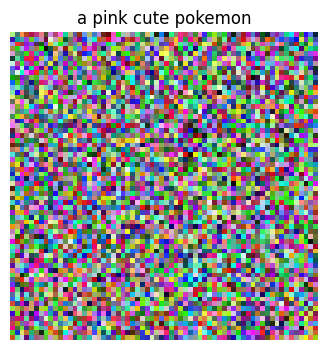

In [ ]:
# 1. Inisialisasi Trainer
trainer = PokemonTrainer(transformer_model, vqvae_encoder)
trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

# 2. Jalankan Training (Kita coba 2 epoch saja agar cepat muncul hasilnya)
print("Memulai Pelatihan...")
trainer.fit(train_ds, epochs=20)

# 3. Fungsi untuk Generate dan Menampilkan Gambar
def generate_pokemon(prompt):
    print(f"Generating: {prompt}...")
    tokenized_text = text_vectorizer([prompt])

    # Generate token visual
    gen_vis_tokens = generate_image_tokens(transformer_model, tokenized_text, 256, 1024)

    # Decode jadi Gambar (Hasilnya akan berupa noise/cokelat sesuai PDF)
    final_image = decode_to_real_image(gen_vis_tokens)

    plt.figure(figsize=(4, 4))
    plt.imshow(final_image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()

# TEST AKHIR
generate_pokemon("a pink cute pokemon")